# Project Report Notebook - Football Transfer Analytics

[Executive_Summary](#Executive_Summary)
<br>[Table of Contents](#Table_of_Contents_Introduction)
<br>[Analysis](#analysis)
<br>[Conclusion](#conclusion)
<br>[Appendix: Project Structure](#Appendix)

---
## Executive Summary <a id='Executive_Summary'></a>

<br>The question: What recipy a football club should follow in order to increase his players market value?

<br>Purpose: We want to analyze what are the most important factors that might increase the value of a player when he transfers from one club to another. Hence, we built a network by taking 10 years of historical data and computed different centrality measurements in order to find out valuable information using machine learning algorithms.

- Network: Transfers of professional and semi-professional football players.
- Type: Directed and weighted network
- Source: [TransferMarket](https://www.transfermarkt.co.uk/).
- Modification: We have scrapped the clubs that have a total market value above 200 million euros. From these clubs, we downloaded the html files of their football players. This include the nationality, birthdate, transfer history, transfer fee etc.

---
## Table of Contents (code) <a id='Table_of_Contents_Introduction'></a>

### 1) [Data Processing](#DataProcessing)
### 2) [Building Graph](#BuildingGraph)
### 3) [Network Centrality Measurements](#CentralityMeasurements)
### 4) [Evaluate Models](#EvaluateModels)
### 5) [Feature Importance](#FeatureImportance)
### 6) [Player Market Value Prediction](#Prediction)

In [29]:
from urllib.request import *
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as pl
import requests
from geopy.geocoders import Nominatim
import json
import folium
import os
import time
from tempfile import TemporaryFile
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
import networkx as nx
from pylab import rcParams
%matplotlib inline

# ML related libraries
from sklearn.linear_model import Lasso
import copy
from sklearn.externals import joblib
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import sklearn.svm as svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn import preprocessing

from models import *
from helpers import *

### Loading clubs data

In [ ]:
with open("../scraper/data/clubs.json", "r") as in_file:
    clubs = json.load(in_file)
print("There are " + str(len(clubs)) + " clubs")
clubs[0]

# Dictionary of club id to name
club_name_id = dict()
for club in clubs:
    club_name_id[club['href'].split("/")[4]] = club['name']

### Loading players data

In [ ]:
with open("../scraper/data/players_ref.json", "r") as in_file:
    players_ref_list = json.load(in_file)

club_ids = []
for club in clubs:
    club_ids.append(int(club['href'].split("/")[-3]))
    
print ("The dataset contains {} players".format(len(players_ref_list)))

## Data Processing <a id='DataProcessing'></a>

***HERE FAYEZ CAN EXPLAIN HOW HE PROCEEDED AND WHAT WAS SO PARTICLUAR IN HIS DATA EXTRACTION METHOD***

In [4]:
# This function will transform the fees of a player from a string to a number so that it can be used as a weight for the edges
def fix_fee(player_fee):
    try:
        player_fee = player_fee.replace(":",": ").replace(",",".")
    except:
        pass
    if re.search(r'\d+.\d+', player_fee) is not None:
        fee = float(re.search(r'\d+.\d+', player_fee).group())
    else:
        fee = 0
    
    if fee > 0:
        if "Mill." in player_fee:
            processed_fee = int(fee*1000000)
        elif "Th." in player_fee:
            processed_fee = int(fee*1000)
        else:
            processed_fee = int(fee)
    else:
        processed_fee = 0
    
    return processed_fee

# Returns the year of the transfer
def get_year(date):
    return date[-4:]

# Define method to parse player given player url
def parsePlayer(player_ref):    
    playerID = player_ref.split("/")[-1]
    
    with open("../scraper/data/players/" + playerID + "/page.html") as in_file:
        player_page = json.load(in_file)
    
    response = BeautifulSoup(player_page, 'html.parser')
    
    playerInfos = str(response.find("table", {"class":"auflistung"}))
    player = {}
    player["href"] = player_ref
    try:
        player["number"] = response.find("span", {"class":"dataRN"}).text
    except:
        player["number"] = None
    player["name"] = response.find("h1", {"itemprop":"name"}).text
    player["player_id"] = player_ref.split("/")[-1]
    position = BeautifulSoup(playerInfos.split("Position")[1], 'html.parser').find("td").text
    reg = re.compile( "[a-zA-Z -]")
    player["position"] = "".join(reg.findall(position))
    try:
        player["birthdate"] = BeautifulSoup(playerInfos.split("Date of birth")[1], 'html.parser').find("td").text
    except:
        player["birthdate"] = None
    player["nationality"] = BeautifulSoup(playerInfos.split("Nationality")[1], 'html.parser').find("td").find("img")["title"]
    player["current_club"] = BeautifulSoup(playerInfos.split("Current club")[1], 'html.parser').find("td").find_all("a")[-1].text

    try:
        transfers = []
        trans = response.find("div",{"class" : "box transferhistorie"}).find("table").find("tbody").find_all("tr", {"class":"zeile-transfer"})

        for t in trans:
            transfer = {}
            transfer["player"] = player_ref.split("/")[-1]
            transfer["date"] = t.find_all("td", {"class":"zentriert hide-for-small"})[1].text
            transfer["from"] = t.find_all("td", {"class":"no-border-rechts vereinswappen"})[0].find("a")["id"]
            transfer["to"] = t.find_all("td", {"class":"no-border-rechts vereinswappen"})[1].find("a")["id"]
            if (t.find("td", {"class":"zelle-abloese"}).text) == "End of loan" or t.find("td", {"class":"zelle-abloese"}).text =="Loan":
                transfer["fee"] = t.find("td", {"class":"zelle-mw"}).text
            else:
                transfer["fee"] = t.find("td",{"class":"zelle-abloese"}).text
            transfer["fee"] = fix_fee(transfer["fee"])
            transfers.append(transfer)
    except:
        transfers = None
        
    return player, transfers


def get_club_value(club_id):
    for club in clubs:
        if (int(club['href'].split("/")[-3]) == club_id):
            return fix_fee(club['market_value'])
    

## Building Graph <a id='BuildingGraph'></a>

In [6]:
# Do not run this cell as it will take a lot of time
transfer = {'from_club_id': [],
            'to_club_id': [],
            'player_nationality': [],
            'value_increase': [],
            'player_stay_in_years': [],
            'club_market_value_from': [],
            'club_market_value_to': [],
            'transfer_year': [],
            'position': [],
            'birth_date_year': []
            }

G = nx.DiGraph()
# Go through all the players
for player_ref in players_ref_list:
    player = parsePlayer(player_ref)
    # Check that player has more than 1 transfer recorded
    if player[1] is not None and len(player[1])>1:
        # Get initial recorded transfer
        year_start = int(get_year(player[1][-1]["date"].strip()))
        # Loop over player transfers from oldest to most recent
        for index in range(2,len(player[1])+1):
            # Compute the number of years a player stayed in the club before he transfered
            player_stay = int(get_year(player[1][-index]["date"].strip())) - year_start
            # Update year_start
            year_start = int(get_year(player[1][-index]["date"].strip()))
            # Only consider the switch when a player stayed less than 5 years in a club
            if (player_stay <= 5):
                from_club = int(player[1][-index]["from"])
                to_club = int(player[1][-index]["to"])
                # Only considering transfers between clubs whose value is above 200 million euros
                if(from_club in club_ids and to_club in club_ids):
                    # Value increase/decrease in a player compared to previous transfer
                    value_increase = player[1][-index]["fee"] - player[1][-index+1]["fee"]
                    # Add entry to dataframe
                    transfer['from_club_id'].append(from_club)
                    transfer['to_club_id'].append(to_club)
                    transfer['player_nationality'].append(player[0]['nationality'])
                    transfer['value_increase'].append(value_increase)
                    transfer['player_stay_in_years'].append(player_stay)
                    transfer['club_market_value_from'].append(get_club_value(from_club))
                    transfer['club_market_value_to'].append(get_club_value(to_club))
                    transfer['transfer_year'].append(get_year(player[1][-index]['date'].strip()))
                    transfer['position'].append(player[0]['position'])
                    transfer['birth_date_year'].append(get_year(player[0]['birthdate'].strip()))
                    # Build graph from the transfer. Each node is a club.
                    # Add two attributes: transfer fee between clubs and number of transfers
                    if G.has_edge(from_club, to_club):
                        G[from_club][to_club]["transfer_fee"] += player[1][-index]["fee"]
                        G[from_club][to_club]["num_transfers"] += 1
                    else:
                        G.add_edge(from_club, to_club, transfer_fee=player[1][-index]["fee"], num_transfers=1)

#### Building Dataframe

In [ ]:
df = pd.DataFrame(transfer, columns= ['from_club_id', 'to_club_id', 'player_nationality', 'value_increase', 
                                      'player_stay_in_years','club_market_value_from', 'club_market_value_to',
                                      'transfer_year','position','birth_date_year'])

## Network Centrality Measurements <a id='CentralityMeasurements'></a>

In [23]:
# Unweighted Degree centrality
unweighted_in_degree_centrality_list = nx.in_degree_centrality(G)
unweighted_out_degree_centrality_list = nx.out_degree_centrality(G)

# Weighted Degree centrality
weighted_in_degree_centrality_list = dict(G.in_degree(weight='transfer_fee'))
weighted_out_degree_centrality_list = dict(G.out_degree(weight='transfer_fee'))

# Other measures
closeness_centrality_list = nx.closeness_centrality(G)
closeness_fee_centrality_list = nx.closeness_centrality(G,distance='transfer_fee')
unweighted_betweenness_centrality_list = nx.betweenness_centrality(G)
weighted_fee_betweenness_centrality_list = nx.betweenness_centrality(G, weight='transfer_fee')
weighted_transfers_betweenness_centrality_list = nx.betweenness_centrality(G, weight='num_transfers')
weighted_fee_pagerank_list = nx.pagerank(G, weight="transfer_fee")
weighted_transfers_pagerank_list = nx.pagerank(G, weight="num_transfers")
unweighted_eigenvector_list = nx.eigenvector_centrality(G)
weighted_fee_eigenvector_list = nx.eigenvector_centrality(G, weight="transfer_fee")
weighted_transfers_eigenvector_list = nx.eigenvector_centrality(G, weight="num_transfers")


#### Add network centrality measurements to dataframe

In [14]:
# Replace in_degree
df['from_in_degree'] = df['from_club_id'].map(lambda x: unweighted_in_degree_centrality_list[x])
df['to_in_degree'] = df['to_club_id'].map(lambda x: unweighted_in_degree_centrality_list[x])

#Replace weighted_in_degree
df['from_fee_in_degree'] = df['from_club_id'].map(lambda x: weighted_in_degree_centrality_list[str(x)])
df['to_fee_in_degree'] = df['to_club_id'].map(lambda x: weighted_in_degree_centrality_list[str(x)])

# Replace out_degree
df['from_out_degree'] = df['from_club_id'].map(lambda x: unweighted_out_degree_centrality_list[x])
df['to_out_degree'] = df['to_club_id'].map(lambda x: unweighted_out_degree_centrality_list[x])

#Replace weighted_out_degree
df['from_fee_out_degree'] = df['from_club_id'].map(lambda x: weighted_out_degree_centrality_list[str(x)])
df['to_fee_out_degree'] = df['to_club_id'].map(lambda x: weighted_out_degree_centrality_list[str(x)])

# Replace closeness
df['from_closeness'] = df['from_club_id'].map(lambda x: closeness_centrality_list[x])
df['to_closeness'] = df['to_club_id'].map(lambda x: closeness_centrality_list[x])

# Replace fee closeness
df['from_fee_closeness'] = df['from_club_id'].map(lambda x: closeness_fee_centrality_list[x])
df['to_fee_closeness'] = df['to_club_id'].map(lambda x: closeness_fee_centrality_list[x])

# Unweighted betweenness
df['from_betweenness'] = df['from_club_id'].map(lambda x: unweighted_betweenness_centrality_list[x])
df['to_betweenness'] = df['to_club_id'].map(lambda x: unweighted_betweenness_centrality_list[x])

# Weighted fee betweenness
df['from_fee_betweenness'] = df['from_club_id'].map(lambda x: weighted_fee_betweenness_centrality_list[x])
df['to_fee_betweenness'] = df['to_club_id'].map(lambda x: weighted_fee_betweenness_centrality_list[x])

# Weighted transfers betweenness
df['from_transfers_betweenness'] = df['from_club_id'].map(lambda x: weighted_transfers_betweenness_centrality_list[x])
df['to_transfers_betweenness'] = df['to_club_id'].map(lambda x: weighted_transfers_betweenness_centrality_list[x])

# Weighted fee pagerank
df['from_fee_pagerank'] = df['from_club_id'].map(lambda x: weighted_fee_pagerank_list[x])
df['to_fee_pagerank'] = df['to_club_id'].map(lambda x: weighted_fee_pagerank_list[x])

# Weighted transfers pagerank
df['from_transfers_pagerank'] = df['from_club_id'].map(lambda x: weighted_transfers_pagerank_list[x])
df['to_transfers_pagerank'] = df['to_club_id'].map(lambda x: weighted_transfers_pagerank_list[x])

# Unweighted eigenvector
df['from_eigenvector'] = df['from_club_id'].map(lambda x: unweighted_eigenvector_list[x])
df['to_eigenvector'] = df['to_club_id'].map(lambda x: unweighted_eigenvector_list[x])

# Weighted fee eigenvector
df['from_fee_eigenvector'] = df['from_club_id'].map(lambda x: weighted_fee_eigenvector_list[x])
df['to_fee_eigenvector'] = df['to_club_id'].map(lambda x: weighted_fee_eigenvector_list[x])

# Weighted transfers eigenvector
df['from_transfers_eigenvector'] = df['from_club_id'].map(lambda x: weighted_transfers_eigenvector_list[x])
df['to_transfers_eigenvector'] = df['to_club_id'].map(lambda x: weighted_transfers_eigenvector_list[x])


In [27]:
def normalize_column(df, feature):
    x = df[[feature]].values.astype(float)

    # Create a minimum and maximum processor object
    min_max_scaler = preprocessing.MinMaxScaler()

    # Create an object to transform the data to fit minmax processor
    x_scaled = min_max_scaler.fit_transform(x)

    # Run the normalizer on the dataframe
    df[feature] = pd.DataFrame(x_scaled)

In [30]:
normalize_column(df, 'from_fee_in_degree')
normalize_column(df, 'from_fee_out_degree')
normalize_column(df, 'to_fee_in_degree')
normalize_column(df, 'to_fee_out_degree')

In [33]:
nx.write_graphml_lxml(G, "transfers.graphml")
df.to_csv("transfers.csv", index=False)

#### Load data from csv and adjlist

In [5]:
df = pd.read_csv("transfers.csv")
G = nx.read_graphml("transfers.graphml")

In [3]:
print('Basic graph information:',nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 401
Number of edges: 9621
Average in degree:  23.9925
Average out degree:  23.9925


We can see that some of the 418 clubs were not present in the graph. That's because the players of these clubs did not transfer to other clubs given the time constraint of 5 years (or no one from the other clubs transfered to them).

## Evaluate Models <a id='EvaluateModels'></a>

#### Build models and compute mean error

In [8]:
SEED = 20
saved_models = []

def build_models(list_of_network_features, normalize = False):
    for columns_to_keep in list_of_network_features:
        models = []
        x_train, y_train, cols = get_data(columns_to_keep)
        if normalize:
            x_train = normalize_feat(x_train)
        
        print ("Build models that include {} network measures".format(columns_to_keep))
        
        # Build Lasso regression
        lasso_regressor = Lasso_Regression(alpha=1e4, seed=SEED)
        models.append(lasso_regressor)
        # Get cross validation error
        mean_error_lasso, std_error_lasso = cross_validation(model_ori=lasso_regressor, input=x_train, labels=y_train, K=5)
        print('* Lasso cross validation error mean: \t\t{}, \t\tstd: {}'.format(int(mean_error_lasso), int(std_error_lasso)))

        # Build KNN regressor
        knn_regressor = KNN()
        models.append(knn_regressor)
        # Get cross validation error
        mean_error_knn, std_error_knn = cross_validation(model_ori=knn_regressor, input=x_train, labels=y_train, K=5)
        print('* KNN cross validation error mean: \t\t{}, \t\tstd: {}'.format(int(mean_error_knn), int(std_error_knn)))

        # Build MLP regressor
        mlp_regressor = MLP(seed=SEED, solver='adam', alpha=1e-5, hidden_layers=(25, 25), lr=1e-4, max_iter=100)
        models.append(mlp_regressor)
        # Get cross validation error
        mean_error_mlp, std_error_mlp = cross_validation(model_ori=mlp_regressor, input=x_train, labels=y_train, K=5)
        print('* MLP cross validation error mean: \t\t{}, \t\tstd: {}'.format(int(mean_error_mlp), int(std_error_mlp)))

        # Build SVR regressor
        svr_regressor = SVR(kernel='linear', seed=SEED)
        models.append(svr_regressor)
        # Get cross validation error
        mean_error_svm, std_error_svm = cross_validation(model_ori=svr_regressor, input=x_train, labels=y_train, K=5)
        print('* SVR cross validation error mean: \t\t{}, \t\tstd: {}'.format(int(mean_error_svm), int(std_error_svm)))

        # Build Random Forest Regressor
        random_forest_regressor = Random_Forest(n_estimators=100, max_depth=20,seed=SEED)
        models.append(random_forest_regressor)
        # Get cross validation error
        mean_error_rf, std_error_rf = cross_validation(model_ori=random_forest_regressor,input=x_train, labels=y_train, K=5)
        print('* Random Forest cross validation error mean: \t{}, \t\tstd: {} \n'.format(int(mean_error_rf), int(std_error_rf)))
        
        saved_models.append(models)

After running a cross-validation on all our models, we could observe that the best model performances are reached with the Random Forest algorithm.

## Feature Importance <a id='FeatureImportance'></a>

In [42]:
x_train, y_train, cols = get_data(['from_in_degree', 'to_in_degree', 'from_out_degree', 'to_out_degree',
       'from_closeness', 'to_closeness', 'from_fee_closeness',
       'to_fee_closeness', 'from_betweenness', 'to_betweenness',
       'from_fee_betweenness', 'to_fee_betweenness',
       'from_transfers_betweenness', 'to_transfers_betweenness',
       'from_fee_pagerank', 'to_fee_pagerank', 'from_transfers_pagerank',
       'to_transfers_pagerank', 'from_eigenvector', 'to_eigenvector',
       'from_fee_eigenvector', 'to_fee_eigenvector',
       'from_transfers_eigenvector', 'to_transfers_eigenvector',
       'from_fee_in_degree', 'to_fee_in_degree', 'from_fee_out_degree',
       'to_fee_out_degree'])
rf_regressor = saved_models[-2][-1].clf.fit(x_train, y_train) # We saved the models in saved_models

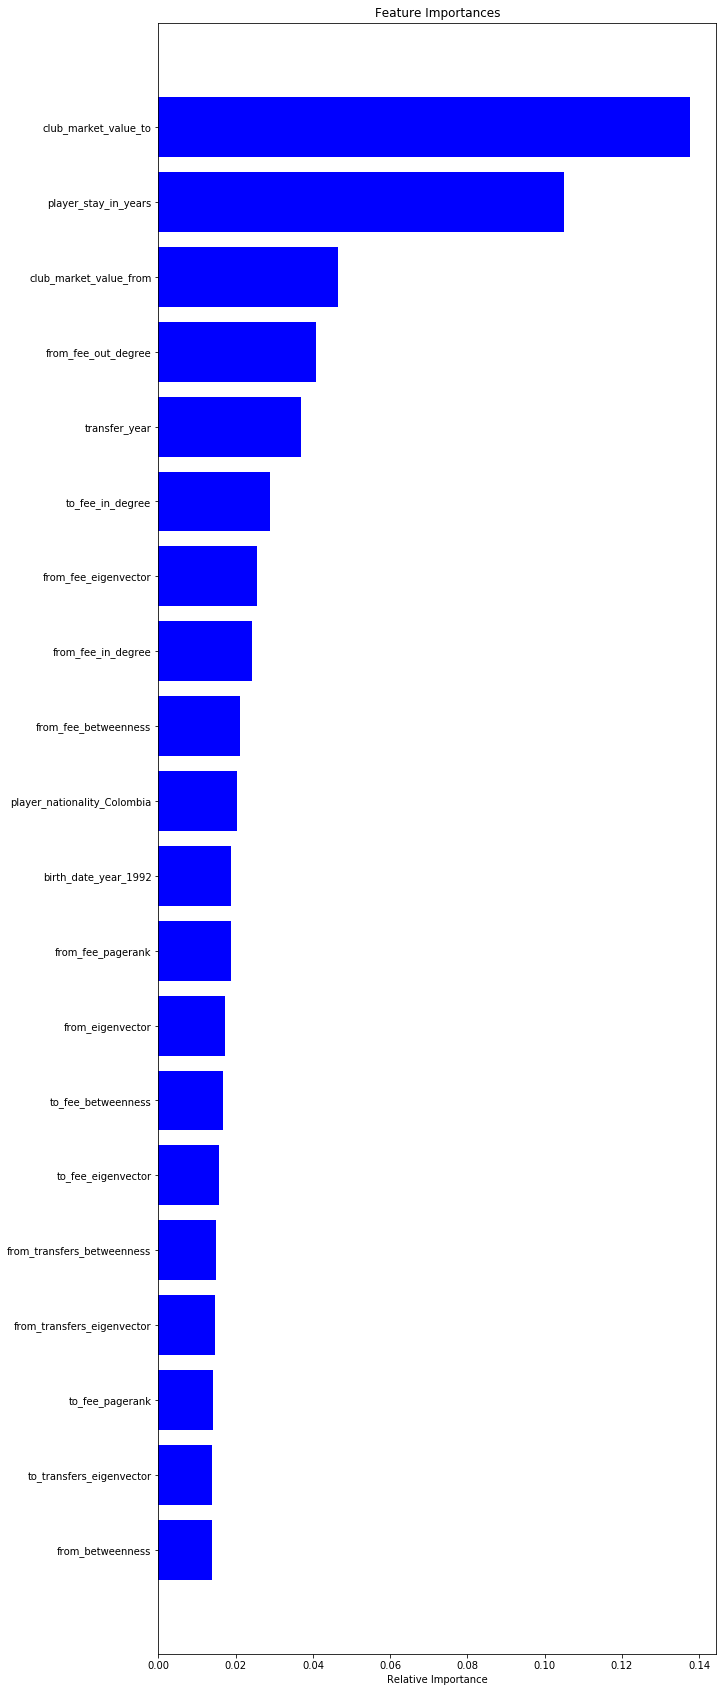

In [43]:
importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[-20:]


plt.figure(figsize=(10,30))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [cols[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

As we want to implement network properties and see if they improve our prediction model, we only look at the most important features  that are network centrality measurements.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

test_model_features = [['from_fee_out_degree','to_fee_in_degree','from_fee_eigenvector', 'from_fee_in_degree']] #Best model

build_models(test_model_features)

We pick our best prediction model and test it with the most important network centrality measurements as features. 
<br>Indeed, with the top 4 network centrality measurements we obtained the best prediction results.

## Player Market Value Prediction <a id='Prediction'></a>

***HERE WE NEED TO DO THE PLAYER MARKET VALUE PREDICTION WITH OUR MODEL AND RETAINED FEATURES***

## Analysis <a id='analysis'></a>

#### Data preprocessing

The network has been built out of 10 pre-selected attributes of football players that transfer from one node (club) to another within 5 years. The edges represent the transfers (player fee and number of transfers between two clubs). In addition, we threshold the market value of the club at 200 million euros. Hence, we ended up with 401 clubs as we can see in the following [section](#Build_graph).
<br>
<br> We then build the dataframe and added centrality measures to our obtained dataframe as seen in [section](#Add_graph).
<br>
<br> All the features have been normalized in order to avoid any bias. 


#### Building model

In the build models function we give it as a input a list of centrality measures, we normalize x_train coming from our dataframe.
<br> We then train five different models (Lasso, k-NN, MLP, SVR et Random Forest).
<br> With cross validation we compute the mean error for each of these models in order to compare their performances.

#### Methodology

1) Intuitivily we chose centrality metrics and tested the different models
<br>2) We keep the best model and looked at feature importance ranking
<br>3) We keep the 4 best centrality measures and evaluate our model again
<br>4) We develop a strategy based on our results

#### Centrality measurement analysis

As we predict the plus value added to a football player transfering to a given club from a given club. In our results we can observe that 'from_fee_out_degree' is the most relevant feature four our selected model. This means that if the player comes from a club that is willing to pay an important amount of money in transfer fees in the past.

<br> The second most important feature is the 'to_fee_in_degree'. This means that the destination club has a history of paying a large amount of transfer fees.

<br> The third feature in our ranking is 'from_fee_eigenvector'. This involves that the origin club of the transfer has relationships with important clubs.

<br> The fourth feature 'from_fee_in_degree' characterizes that the orgirin club is of importance (bought high value football players). However, this centrality measurement doesn't seem to be necessary to predict a club that would make a plus value. This limitation might appear from the fact that our dataset only contains extremely wealthy clubs.

## Conclusion <a id='conclusion'></a>

As a conclusion our model isn't limited to prediction but advise a club on how to sell a player in order to make the highest profit.
<br> Our study reveals that the important elements in decision making such as the market value of the destination club, number of years stayed within the same club and market value of the original club are not the only features to look at.
<br> Our findings show that centrality measurements such as 'from_fee_out_degree' play an important role when it comes to predict the best recipy for a succesfull player transfer, maximizing the clubs income.
<br>
<br> Finally, our model is working well but doesn't include all the clubs. Hence, we could improve it by lowering the threshold of the market cap of the clubs.


## Appendix: Project Structure <a id='Appendix'></a>

In the /graph folder:
<br>'helpers.py' contains all the helper function necessary for data processing
<br>'models.py' contains all the machine learning models definition
<br>'transfers.csv^ is a data file
<br>'transfers.graphml' contains the network
<br>'transfers_graph' contains the adjacency list of the network